In [55]:
import matplotlib.pyplot as plt # matplot lib is the premiere plotting lib for Python: https://matplotlib.org/
import numpy as np # numpy is the premiere signal handling library for Python: http://www.numpy.org/
import scipy as sp # for signal processing
from scipy import signal
from scipy.spatial import distance
import IPython.display as ipd
import librosa
import random
import math
import fastdtw
from numpy.fft import fft, ifft, fft2, ifft2, fftshift

In [56]:
import matplotlib.pyplot as plt # matplot lib is the premiere plotting lib for Python: https://matplotlib.org/
import numpy as np # numpy is the premiere signal handling library for Python: http://www.numpy.org/
import scipy as sp # for signal processing
from scipy import signal
from scipy.spatial import distance
import librosa
import random

### SINE AND COSINE GENERATOR FUNCTIONS ###

def create_sine_waves(freqs, sampling_rate, total_time_in_secs = None, return_time = False):
    '''Creates multiple sine waves corresponding to the freq array, sampling rate, and length
    
       Returns a tuple list of (freq, sine_wave) or (freq, (time, sine_wave))
       depending on whether return_time is True or False
    '''
    sine_waves = []
    for freq in freqs:
        sine_waves.append((freq, create_sine_wave(freq, sampling_rate, total_time_in_secs, return_time)))
    return sine_waves

def create_sine_wave_sequence(freqs, sampling_rate, time_per_freq = None, starting_amplitudes = None,
                             ending_amplitudes = None):

    '''
    Creates a sine wave sequence at the given frequencies and sampling rate. You can control
    the time per frequency via time_per_freq and the starting and ending amplitudes of each signal
    
    Parameters:
        freqs (array): array of frequencies
        sampling_rate (num): sampling rate
        time_per_freq (float or list): If a float, creates all sine waves of that length (in secs).
            If an array, takes the time per frequency (in secs). If None, sets all sine waves to length 1 sec.
        starting_amplitudes (array): List of starting amplitudes for each freq (one by default)
        ending_amplitudes (array): list of ending amplitudes for each freq (zero by default)
    '''
    if starting_amplitudes is None:
        starting_amplitudes = np.ones(len(freqs))

    if ending_amplitudes is None:
        ending_amplitudes = np.zeros(len(freqs))

    if time_per_freq is None:
        time_per_freq = np.ones(len(freqs))
    elif isinstance(time_per_freq, (list, tuple, np.ndarray)) is False:
        time_per_freq = np.full(len(freqs), time_per_freq)

    signal_sequence = np.array([])
    for i, freq in enumerate(freqs):
        signal = create_sine_wave(freq, sampling_rate, time_per_freq[i])
        
        # Currently linear interpolation between start and end amplitudes
        # But we could expand this later to exponential, etc.
        amplitudes = np.linspace(starting_amplitudes[i], ending_amplitudes[i], num=len(signal))
        signal_with_amplitudes = signal * amplitudes
        signal_sequence = np.concatenate((signal_sequence, signal_with_amplitudes))
    
    return signal_sequence

def create_composite_sine_wave(freqs, sampling_rate, total_time_in_secs, amplitudes = None,
                              use_random_amplitudes = False, return_time = False):
    '''Creates a composite sine wave with the given frequencies and amplitudes'''
    
    if amplitudes is None and use_random_amplitudes is False:
        amplitudes = np.ones(len(freqs))
    elif amplitudes is None and use_random_amplitudes is True:
        amplitudes = np.random.uniform(low = 0.1, high = 1, size=(len(freqs)))

    time = np.arange(total_time_in_secs * sampling_rate) / sampling_rate
    signal_composite = np.zeros(len(time)) # start with empty array
    for i, freq in enumerate(freqs):
        # set random amplitude for each freq (you can change this, of course)
        signal = amplitudes[i] * create_sine_wave(freq, sampling_rate, total_time_in_secs)
        signal_composite += signal

    if return_time is False:
        return signal_composite
    else:
        return (time, signal_composite)

def create_sine_wave(freq, sampling_rate, total_time_in_secs = None, return_time = False):
    '''Creates a sine wave with the given frequency, sampling rate, and length'''
    
    # if the total time in secs is None, then return one period of the wave
    if total_time_in_secs is None:
        total_time_in_secs = 1 / freq

    # Create an array from 0 to total_time_in_secs * sampling_rate (and then divide by sampling
    # rate to get each time_step)
    time = np.arange(total_time_in_secs * sampling_rate) / sampling_rate
    
    # Could also generate this signal by:
    # time = np.linspace(0, total_time_in_secs, int(total_time_in_secs * sampling_rate), endpoint=False)

    sine_wave = np.sin(2 * np.pi * freq * time)

    # or, once the sample is made:
    # time = np.linspace(0, len(s) / sampling_rate, num=len(s))

    if return_time is False:
        return sine_wave
    else:
        return (time, sine_wave)

def create_cos_wave(freq, sampling_rate, total_time_in_secs = None, return_time = False):
    '''Creates a cos wave with the given frequency, sampling rate, and length'''
    
     # if the total time in secs is None, then return one period of the wave
    if total_time_in_secs is None:
        total_time_in_secs = 1 / freq

    # Create an array from 0 to total_time_in_secs * sampling_rate (and then divide by sampling
    # rate to get each time_step)
    time = np.arange(total_time_in_secs * sampling_rate) / sampling_rate
    cos_wave = np.cos(2 * np.pi * freq * time)

    if return_time is False:
        return cos_wave
    else:
        return (time, cos_wave)

def get_random_xzoom(signal_length, fraction_of_length):
    '''Returns a tuple of (start, end) for a random xzoom amount''' 
    zoom_length = int(signal_length * fraction_of_length)
    random_start = random.randint(0, signal_length - zoom_length)
    xlim_zoom = (random_start, random_start + zoom_length)
    return xlim_zoom

def map(val, start1, stop1, start2, stop2):
    '''Similar to Processing and Arduino's map function'''
    return ((val-start1)/(stop1-start1)) * (stop2 - start2) + start2

def remap(val, start1, stop1, start2, stop2):
    '''Similar to Processing and Arduino's map function'''
    return ((val-start1)/(stop1-start1)) * (stop2 - start2) + start2

### SIGNAL MANIPULATION FUNCTIONS ###

# While numpy provides a roll function, it does not appear to provide a shift
# https://stackoverflow.com/q/30399534
# So, lots of people have implemented their own, including some nice benchmarks here:
# https://stackoverflow.com/a/42642326
def shift_array(arr, shift_amount, fill_value = np.nan):
    '''Shifts the array either left or right by the shift_amount (which can be negative or positive)
     
       From: https://stackoverflow.com/a/42642326
    '''
    result = np.empty_like(arr)
    if shift_amount > 0:
        result[:shift_amount] = fill_value
        result[shift_amount:] = arr[:-shift_amount]
    elif shift_amount < 0:
        result[shift_amount:] = fill_value
        result[:shift_amount] = arr[-shift_amount:]
    else:
        result[:] = arr
    return result

### SIGNAL ANALYSIS FUNCTIONS ###

# TODO: update get_top_n_frequency_indices_sorted so that you can specify a min_gap
#       between top freqs (so if two top freqs are close together, one can be skipped)
def get_top_n_frequency_indices_sorted(n, freqs, amplitudes):
    '''Gets the top N frequency indices (sorted)'''
    ind = np.argpartition(amplitudes, -n)[-n:] # from https://stackoverflow.com/a/23734295
    ind_sorted_by_coef = ind[np.argsort(-amplitudes[ind])] # reverse sort indices

    return ind_sorted_by_coef

def calc_zero_crossings(s, min_gap = None):
    '''Returns the number of zero crossings in the signal s
    
    This method is based on https://stackoverflow.com/q/3843017
    
    Parameters:
    s: the signal
    min_gap: the minimum gap (in samples) between zero crossings
    TODO:     
    - could have a mininum height after the zero crossing (within some window) to eliminate noise
    '''
    # I could not get the speedier Pythonista solutions to work reliably so here's a 
    # custom non-Pythony solution
    cur_pt = s[0]
    zero_crossings = []
    last_zero_crossing_idx = None
    last_zero_cross_idx_saved = None
    for i in range(1, len(s)):
        next_pt = s[i]
        zero_crossing_idx = None
        
        # There are three cases to check for:
        #  1. If the cur_pt is gt zero and the next_pt is lt zero, obviously a zero crossing.
        #     Similarly, if the next_pt is gt zero and the cut_pt is lt zero, again a zero crossing
        #  2. If the cur_pt is zero and the next_pt gt zero, then we walk back to see when zero 
        #     was first "entered"
        #  3. Finally, if the cut_pt is zero and the next_pt lt zero, we again walk back to see
        #     when zero was first "entered"
        if ((next_pt < 0 and cur_pt > 0) or (next_pt > 0 and cur_pt < 0)):
            # if we're here, a zero crossing occurred
            zero_crossing_idx = i
          
        elif cur_pt == 0 and next_pt > 0:
            # check for previous points less than 0
            # as soon as tmp_pt is not zero, we are done
            tmp_pt = cur_pt
            walk_back_idx = i
            while(tmp_pt == 0 and walk_back_idx > 0):
                walk_back_idx -= 1
                tmp_pt = s[walk_back_idx]
            
            if tmp_pt < 0:
                zero_crossing_idx = i
                
        elif cur_pt == 0 and next_pt < 0:
            # check for previous points greater than 0
            # as soon as tmp_pt is not zero, we are done
            tmp_pt = cur_pt
            walk_back_idx = i
            while(tmp_pt == 0 and walk_back_idx > 0):
                walk_back_idx -= 1
                tmp_pt = s[walk_back_idx]
            
            if tmp_pt > 0:
                zero_crossing_idx = i
        
        # now potentially add zero_crossing_idx to our list
        if zero_crossing_idx is not None:
            # potentially have a new zero crossing, check for other conditions
            if last_zero_cross_idx_saved is None or \
               last_zero_cross_idx_saved is not None and min_gap is None or \
               (min_gap is not None and (i - last_zero_cross_idx_saved) > min_gap):
                
                zero_crossings.append(zero_crossing_idx) # save the zero crossing point
                last_zero_cross_idx_saved = zero_crossing_idx
            
            last_zero_crossing_idx = zero_crossing_idx
            
        cur_pt = s[i]
    return zero_crossings

##### VISUALIZATION CODE ######
def plot_signal_to_axes(ax, s, sampling_rate, title=None, signal_label=None, marker=None):
    '''Plots a sine wave s with the given sampling rate
    
    Parameters:
    ax: matplot axis to do the plotting
    s: numpy array
    sampling_rate: sampling rate of s
    title: chart title
    signal_label: the label of the signal
    '''
    ax.plot(s, label=signal_label, marker=marker, alpha=0.9)
    ax.set(xlabel="Samples")
    ax.set(ylabel="Amplitude")
    if signal_label is not None:
        ax.legend()

    # we use y=1.14 to make room for the secondary x-axis
    # see: https://stackoverflow.com/questions/12750355/python-matplotlib-figure-title-overlaps-axes-label-when-using-twiny
    if title is not None:
        ax.set_title(title, y=1.1)
    
    ax.grid()

    # add in a secondary x-axis to draw the x ticks as time (rather than samples)
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    
    ax_ticks = ax.get_xticks()[1:-1]
    ax2_tick_labels = ax.get_xticks()[1:-1] / sampling_rate

    num_samples_shown = ax.get_xlim()[1] - ax.get_xlim()[0]
    time_shown = num_samples_shown / sampling_rate
    if time_shown < 1:
        ax2.set_xlabel("Time (ms)")
        # format with 'g' causes insignificant trailing zeroes to be removed
        # https://stackoverflow.com/a/2440708 but also uses scientific notation, oh well!
        ax2_tick_labels = [f"{x * 1000:.1f}" for x in ax2_tick_labels]
    else:
        ax2.set_xlabel("Time (secs)")
        ax2_tick_labels = ['{:.2f}'.format(x) for x in ax2_tick_labels]

    ax2.set_xticks(ax_ticks)
    ax2.set_xticklabels(ax2_tick_labels)

def plot_audio(s, sampling_rate, quantization_bits = 16, title = None, xlim_zoom = None, highlight_zoom_area = True):
    ''' Calls plot_Signal but accepts quantization_bits '''
    plot_title = title
    if plot_title is None:
        plot_title = f"{quantization_bits}-bit, {sampling_rate} Hz audio"
    
    return plot_signal(s, sampling_rate, title = title, xlim_zoom = xlim_zoom, highlight_zoom_area = highlight_zoom_area)

def plot_signal(s, sampling_rate, title = None, xlim_zoom = None, highlight_zoom_area = True):
    '''Plots time-series data with the given sampling_rate and xlim_zoom'''
    
    plot_title = title
    if plot_title is None:
        plot_title = f"Sampling rate: {sampling_rate} Hz"

    if xlim_zoom == None:
        fig, axes = plt.subplots(1, 1, figsize=(15,6))
        
        plot_signal_to_axes(axes, s, sampling_rate, plot_title)
        return (fig, axes)
    else:
        fig, axes = plt.subplots(1, 2, figsize=(15,6), sharey=True, gridspec_kw={'width_ratios': [2, 1]})
        plot_signal_to_axes(axes[0], s, sampling_rate, plot_title)
        
        # if(xlim_zoom == None):
        #     xlim_zoom = get_random_xzoom(len(audio_data), 0.1)
        
        if highlight_zoom_area:
            # yellow highlight color: color='#FFFBCC'
            axes[0].axvspan(xlim_zoom[0], xlim_zoom[1], color='orange', alpha=0.3)
            
        axes[1].set_xlim(xlim_zoom)
        zoom_title = f"Signal zoomed: {int(xlim_zoom[0])} - {int(xlim_zoom[1])} samples"
        plot_signal_to_axes(axes[1], s, sampling_rate, zoom_title)
        axes[1].set_ylabel(None)
        fig.tight_layout()
        return (fig, axes)

def plot_sampling_demonstration(total_time_in_secs, real_world_freqs, real_world_continuous_speed = 10000, resample_factor = 200):
    '''Used to demonstrate digital sampling and uses stem plots to show where samples taken'''
    num_charts = len(real_world_freqs)
    fig_height = num_charts * 3.25
    fig, axes = plt.subplots(num_charts, 1, figsize=(15, fig_height))
    
    time = None
    
    i = 0
    sampling_rate = real_world_continuous_speed / resample_factor
    print(f"Sampling rate: {sampling_rate} Hz")
    for real_world_freq in real_world_freqs:
        time, real_world_signal = create_sine_wave(real_world_freq, real_world_continuous_speed, 
                                               total_time_in_secs, return_time = True)
        sampled_time = time[::resample_factor]
        sampled_signal = real_world_signal[::resample_factor]
        
        axes[i].plot(time, real_world_signal)
        axes[i].axhline(0, color="gray", linestyle="-", linewidth=0.5)
        axes[i].plot(sampled_time, sampled_signal, linestyle='None', alpha=0.8, marker='s', color='black')
        axes[i].vlines(sampled_time, ymin=0, ymax=sampled_signal, linestyle='-.', alpha=0.8, color='black')
        axes[i].set_ylabel("Amplitude")
        axes[i].set_xlabel("Time (secs)")
        axes[i].set_title(f"{real_world_freq}Hz signal sampled at {sampling_rate}Hz")
        
        i += 1
    fig.tight_layout(pad = 3.0)

#### FREQUENCY VISUALIZATIONS ####
def plot_signal_and_magnitude_spectrum(t, s, sampling_rate, title = None, xlim_zoom_in_secs = None):
    # Plot the time domain
    ax_main_time = None
    ax_zoom_time = None
    ax_spectrum = None
    
    axes = []
    if xlim_zoom_in_secs is None:
        fig, axes = plt.subplots(2, 1, figsize=(15,8))
        ax_main_time = axes[0]
        ax_spectrum = axes[1]
    else:
        fig = plt.figure(figsize=(15, 9))

        # TODO: in future, ideally, we would have like a 70/30 split on top row
        ax_main_time = plt.subplot2grid((2, 2), (0, 0))
        ax_zoom_time = plt.subplot2grid((2, 2), (0, 1))
        ax_spectrum = plt.subplot2grid((2, 2), (1, 0), colspan=2)
        axes.append(ax_main_time)
        axes.append(ax_zoom_time)
        axes.append(ax_spectrum)
    
    # Plot main time domain
    ax_main_time.plot(t, s)
    
    if title is None:
        title = "Signal (time domain)"
    
    ax_main_time.set_title(title)
    ax_main_time.set_ylabel("Amplitude")
    ax_main_time.set_xlabel("Time (secs)")
    
    if ax_zoom_time is not None:
        # plot zoom
        ax_main_time.axvspan(xlim_zoom_in_secs[0], xlim_zoom_in_secs[1], color='orange', alpha=0.3)
        
        ax_zoom_time.set_xlim(xlim_zoom_in_secs)
        ax_zoom_time.plot(t, s)  
        ax_zoom_time.set_title(title + " (Zoomed)")
        ax_zoom_time.set_ylabel("Amplitude")
        ax_zoom_time.set_xlabel("Time (secs)")

    # Plot the frequency transform
    ax_spectrum.magnitude_spectrum(s, Fs = sampling_rate, color='r')
    fig.tight_layout()

    return (fig, axes)

import matplotlib.ticker as ticker
def plot_spectrogram_to_axes(ax, s, sampling_rate, title=None, 
                             marker=None, custom_axes = True):
    '''Plots a spectrogram wave s with the given sampling rate
    
    Parameters:
    ax: matplot axis to do the plotting
    s: numpy array
    sampling_rate: sampling rate of s
    title: chart title
    '''

    specgram_return_data = ax.specgram(s, Fs=sampling_rate)

    # we use y=1.14 to make room for the secondary x-axis
    # see: https://stackoverflow.com/questions/12750355/python-matplotlib-figure-title-overlaps-axes-label-when-using-twiny
    if title is not None:
        ax.set_title(title, y=1.2)

    ax.set_ylabel("Frequency")

    # add in a secondary x-axis to draw the x ticks as time (rather than samples)
    if custom_axes:
        ax.set(xlabel="Samples")
        ax_xtick_labels = np.array(ax.get_xticks()) * sampling_rate
        ax_xtick_labels_strs = [f"{int(xtick_label)}" for xtick_label in ax_xtick_labels]
        ax.set_xticklabels(ax_xtick_labels_strs)

        ax2 = ax.twiny()
        ax2.set_xlim(ax.get_xlim())
        ax2.set_xlabel("Time (secs)")
        ax2_tick_labels = ax_xtick_labels / sampling_rate
        ax2_tick_labels_strs = [f"{xtick_label:.1f}s" for xtick_label in ax2_tick_labels]
        ax2.set_xticks(ax.get_xticks())
        ax2.set_xticklabels(ax2_tick_labels_strs)
    return specgram_return_data
    
def plot_spectrogram(s, sampling_rate, title = None, xlim_zoom = None, highlight_zoom_area = True):
    '''Plots signal with the given sampling_Rate, quantization level, and xlim_zoom'''
    fig, axes = plt.subplots(1, 2, figsize=(15,4), gridspec_kw={'width_ratios': [2, 1]})
    
    if title is None:
        title = f"{len(s) * sampling_rate} sec Signal with {sampling_rate} Hz"
    
    specgram_return_data0 = plot_spectrogram_to_axes(axes[0], s, sampling_rate, title)
    
    if(xlim_zoom == None):
        max_length = len(s)
        length = int(max_length * 0.1)
        random_start = random.randint(0, max_length - length)
        xlim_zoom = (random_start, random_start + length)
      
    axes[1].set_xlim(xlim_zoom)
    #axes[1].set_xlim(12000, 14000)
    specgram_return_data1 = plot_spectrogram_to_axes(axes[1], s, sampling_rate, title + ' (Zoomed)', custom_axes = False)
    
    zoom_x1 = xlim_zoom[0] / sampling_rate
    zoom_x2 = xlim_zoom[1] / sampling_rate
    axes[1].set_xlim(zoom_x1, zoom_x2) # but this one seems to work
    
    ax2 = axes[1].twiny()
    ax2.set_xlim(axes[1].get_xlim())
    ax2.set_xticks(axes[1].get_xticks())
    ax2_tick_labels_strs = [f"{xtick_label:.1f}s" for xtick_label in axes[1].get_xticks()]
    ax2.set_xticklabels(ax2_tick_labels_strs)
    ax2.set_xlabel("Time (secs)")
    
    ax_xtick_labels = np.array(axes[1].get_xticks()) * sampling_rate
    ax2_tick_labels_strs = [f"{int(xtick_label)}" for xtick_label in ax_xtick_labels]
    axes[1].set(xlabel="Samples")
    axes[1].set_xticklabels(ax2_tick_labels_strs)
    
    if highlight_zoom_area:
        # yellow highlight color: color='#FFFBCC'
        axes[0].axvline(x = zoom_x1, linewidth=2, color='r', alpha=0.8, linestyle='-.')
        axes[0].axvline(x = zoom_x2, linewidth=2, color='r', alpha=0.8, linestyle='-.')
    
    fig.tight_layout()
    return (fig, axes, specgram_return_data0, specgram_return_data1)

def plot_signal_and_spectrogram(s, sampling_rate, quantization_bits, xlim_zoom = None, highlight_zoom_area = True):
    '''Plot waveforms and spectrograms together'''
    fig = plt.figure(figsize=(15, 9))
    spec = fig.add_gridspec(ncols = 2, nrows = 2, width_ratios = [2, 1], height_ratios = [1, 1])
    plot_title = f"{quantization_bits}-bit, {sampling_rate} Hz audio"
    
    ax_waveform1 = plt.subplot(spec[0, 0])
    ax_waveform1.set_xlim(0, len(s))
    ax_waveform2 = plt.subplot(spec[0, 1], sharey = ax_waveform1)

    ax_spectrogram1 = plt.subplot(spec[1, 0])
    ax_spectrogram2 = plt.subplot(spec[1, 1])

    plot_signal_to_axes(ax_waveform1, s, sampling_rate, plot_title)
    specgram_return_data = plot_spectrogram_to_axes(ax_spectrogram1, s, sampling_rate, plot_title)
    #print(len(specgram_return_data[2]))
    
    #print(ax_waveform1.get_xlim())
    #print(ax_spectrogram1.get_xlim())
    waveform_xrange = ax_waveform1.get_xlim()[1] - ax_waveform1.get_xlim()[0]

    ax_waveform2.set_xlim(xlim_zoom)
    plot_signal_to_axes(ax_waveform2, s, sampling_rate, plot_title + ' zoomed')
    
    zoom_x1 = remap(xlim_zoom[0], ax_waveform1.get_xlim()[0], ax_waveform1.get_xlim()[1], 
                    ax_spectrogram1.get_xlim()[0], ax_spectrogram1.get_xlim()[1])
    zoom_x2 = remap(xlim_zoom[1], ax_waveform1.get_xlim()[0], ax_waveform1.get_xlim()[1], 
                    ax_spectrogram1.get_xlim()[0], ax_spectrogram1.get_xlim()[1])
    
    #print(ax_spectrogram2.get_xlim(), zoom_x1, zoom_x2)
    ax_spectrogram2.set_xlim(zoom_x1, zoom_x2) # this won't make a difference
    plot_spectrogram_to_axes(ax_spectrogram2, s, sampling_rate, plot_title, 
                             custom_axes = False)
    ax_spectrogram2.set_xlim(zoom_x1, zoom_x2) # but this one seems to work
     
    ax2 = ax_spectrogram2.twiny()
    ax2.set_xlim(ax_spectrogram2.get_xlim())
    ax2.set_xticks(ax_spectrogram2.get_xticks())
    ax2_tick_labels_strs = [f"{xtick_label:.2f}s" for xtick_label in ax_spectrogram2.get_xticks()]
    ax2.set_xticklabels(ax2_tick_labels_strs)
    ax2.set_xlabel("Time (secs)")
    
    ax_xtick_labels = np.array(ax_spectrogram2.get_xticks()) * sampling_rate
    ax2_tick_labels_strs = [f"{int(xtick_label)}" for xtick_label in ax_xtick_labels]
    ax_spectrogram2.set(xlabel="Samples")
    ax_spectrogram2.set_xticks(ax_spectrogram2.get_xticks())
    ax_spectrogram2.set_xticklabels(ax2_tick_labels_strs)
    
    if highlight_zoom_area:
        # yellow highlight color: color='#FFFBCC'
        ax_waveform1.axvspan(xlim_zoom[0], xlim_zoom[1], color='orange', alpha=0.3)
        ax_spectrogram1.axvline(x = zoom_x1, linewidth=2, color='r', alpha=0.8, linestyle='-.')
        ax_spectrogram1.axvline(x = zoom_x2, linewidth=2, color='r', alpha=0.8, linestyle='-.')
    
    fig.tight_layout()

In [57]:
def pad_zeros_right(s, padding_length):
    # https://numpy.org/doc/1.18/reference/generated/numpy.pad.html
    return np.pad(s, (0, padding_length), mode = 'constant', constant_values=0)

def pad_mean_right(s, padding_length):
    # https://numpy.org/doc/1.18/reference/generated/numpy.pad.html
    return np.pad(s, (0, padding_length), mode = 'mean')

# def compare_and_plot_signals(a, b, distance_function = distance.euclidean, alignment_function = None):
def plot_signals_with_alignment(a, b, pad_function = None):
    if(len(a) != len(b) and pad_function is None):
        raise Exception(f"Signal 'a' and 'b' must be the same size; len(a)={len(a)} and len(b)={len(b)} or pad_function must not be None")
    elif(len(a) != len(b) and pad_function is not None):
        if(len(a) < len(b)):
            a = pad_function(a, len(b) - len(a))
        else:
            b = pad_function(b, len(a) - len(b))
    
    correlate_result = np.correlate(a, b, 'full')
    shift_positions = np.arange(-len(a) + 1, len(b))
    
    print("len(a)", len(a), "len(b)", len(b), "len(correlate_result)", len(correlate_result))

    fig, axes = plt.subplots(5, 1, figsize=(10, 18))
    
    axes[0].plot(a, alpha=0.7, label="a", marker="o")
    axes[0].plot(b, alpha=0.7, label="b", marker="D")
    axes[0].legend()
    axes[0].set_title("Raw Signals 'a' and 'b'")
    
    if len(shift_positions) < 20:
        # useful for debugging and showing correlation results
        print(shift_positions)
        print(correlate_result)

    best_correlation_index = np.argmax(correlate_result)
    shift_amount_debug = shift_positions[best_correlation_index]
    shift_amount = (-len(a) + 1) + best_correlation_index
    print("best_correlation_index", best_correlation_index, "shift_amount_debug", shift_amount_debug, "shift_amount", shift_amount)
    
    axes[1].stem(shift_positions, correlate_result, use_line_collection=True, label="Cross-correlation of a and b")
    axes[1].set_title(f"Cross-Correlation Result | Best Match Index: {best_correlation_index} Signal 'b' Shift Amount: {shift_amount}")
    axes[1].set_ylabel("Cross Correlation")
    axes[1].set_xlabel("'b' Signal Shift Amount")
    
    best_match_ymin = 0
    best_match_ymin_normalized =  map(best_match_ymin, axes[1].get_ylim()[0], axes[1].get_ylim()[1], 0, 1)
    best_match_ymax = correlate_result[best_correlation_index]
    best_match_ymax_normalized =  map(best_match_ymax, axes[1].get_ylim()[0], axes[1].get_ylim()[1], 0, 1)
    axes[1].axvline(shift_positions[best_correlation_index], ymin=best_match_ymin_normalized, ymax=best_match_ymax_normalized, 
                    linewidth=2, color='orange', alpha=0.8, linestyle='-.', 
                    label=f"Best match ({shift_amount}, {best_match_ymax:.2f})")
    axes[1].legend()
    b_shifted_mean_fill =  shift_array(b, shift_amount, np.mean(b))
    axes[2].plot(a, alpha=0.7, label="a", marker="o")
    axes[2].plot(b_shifted_mean_fill, alpha=0.7, label="b_shifted_mean_fill", marker="D")
    axes[2].legend()
    axes[2].set_title("Signals 'a' and 'b_shifted_mean_fill'")
    
    b_shifted_zero_fill =  shift_array(b, shift_amount, 0)
    axes[3].plot(a, alpha=0.7, label="a", marker="o")
    axes[3].plot(b_shifted_zero_fill, alpha=0.7, label="b_shifted_zero_fill", marker="D")
    axes[3].legend()
    axes[3].set_title("Signals 'a' and 'b_shifted_zero_fill'")
    
    b_shifted_roll = np.roll(b, shift_amount)
    axes[4].plot(a, alpha=0.7, label="a", marker="o")
    axes[4].plot(b_shifted_roll, alpha=0.7, label="b_shifted_roll", marker="D")
    axes[4].legend()
    axes[4].set_title("Signals 'a' and 'b_shifted_roll'")
    
    fig.tight_layout()
    
def compare_and_plot_signals_with_alignment(a, b, bshift_method = 'mean_fill', pad_function = None):
    '''Aligns signals using cross correlation and then plots
    
       bshift_method can be: 'mean_fill', 'zero_fill', 'roll', or 'all'. Defaults to 'mean_fill'
    '''
    b_shift = None
    if(len(a) != len(b) and pad_function is None):
        raise Exception(f"Signal 'a' and 'b' must be the same size; len(a)={len(a)} and len(b)={len(b)} or pad_function must not be None")
    elif(len(a) != len(b) and pad_function is not None):
        if(len(a) < len(b)):
            a = pad_function(a, len(b) - len(a))
        else:
            b = pad_function(b, len(a) - len(b))
    
    correlate_result = np.correlate(a, b, 'full')
    shift_positions = np.arange(-len(a) + 1, len(b))
    print("len(a)", len(a), "len(b)", len(b), "len(correlate_result)", len(correlate_result))
    
    euclid_distance_a_to_b = distance.euclidean(a, b)
    
    num_charts = 3
    chart_height = 3.6
    if bshift_method is 'all':
        num_charts = 5
    
    fig, axes = plt.subplots(num_charts, 1, figsize=(10, num_charts * chart_height))
    
    # Turn on markers only if < 50 points
    a_marker = None
    b_marker = None
    if len(a) < 50:
        a_marker = "o"
        b_marker = "D"
        
    axes[0].plot(a, alpha=0.7, label="a", marker=a_marker)
    axes[0].plot(b, alpha=0.7, label="b", marker=b_marker)
    axes[0].legend()
    axes[0].set_title(f"Raw Signals | Euclidean Distance From 'a' to 'b' = {euclid_distance_a_to_b:.2f}")
    
    if len(shift_positions) < 20:
        # useful for debugging and showing correlation results
        print(shift_positions)
        print(correlate_result)
    
    best_correlation_index = np.argmax(correlate_result)
    shift_amount_debug = shift_positions[best_correlation_index]
    shift_amount = (-len(a) + 1) + best_correlation_index
    print("best_correlation_index", best_correlation_index, "shift_amount_debug", shift_amount_debug, "shift_amount", shift_amount)
    
    #axes[1].plot(shift_positions, correlate_result)
    axes[1].stem(shift_positions, correlate_result, use_line_collection=True, label="Cross-correlation of a and b")
    axes[1].set_title(f"Cross-correlation result | Best match index: {best_correlation_index}; Signal 'b' shift amount: {shift_amount}")
    axes[1].set_ylabel("Cross Correlation")
    axes[1].set_xlabel("'b' Signal Shift Amount")
    
    best_match_ymin = 0
    best_match_ymin_normalized =  map(best_match_ymin, axes[1].get_ylim()[0], axes[1].get_ylim()[1], 0, 1)
    best_match_ymax = correlate_result[best_correlation_index]
    best_match_ymax_normalized =  map(best_match_ymax, axes[1].get_ylim()[0], axes[1].get_ylim()[1], 0, 1)
    axes[1].axvline(shift_positions[best_correlation_index], ymin=best_match_ymin_normalized, ymax=best_match_ymax_normalized, 
                    linewidth=2, color='orange', alpha=0.8, linestyle='-.', 
                    label=f"Best match ({shift_amount}, {best_match_ymax:.2f})")
    axes[1].legend()
    
    if bshift_method is 'mean_fill' or bshift_method is 'all':
        b_shifted_mean_fill =  shift_array(b, shift_amount, np.mean(b))
        euclid_distance_a_to_b_shifted_mean_fill = distance.euclidean(a, b_shifted_mean_fill)
        axes[2].plot(a, alpha=0.7, label="a", marker=a_marker)
        axes[2].plot(b_shifted_mean_fill, alpha=0.7, label="b_shifted_mean_fill", marker=b_marker)
        axes[2].legend()
        axes[2].set_title(f"Euclidean distance From 'a' to 'b_shifted_mean_fill' = {euclid_distance_a_to_b_shifted_mean_fill:.2f}")
        b_shift = b_shifted_mean_fill
    ax_idx = 0
    if bshift_method is 'zero_fill' or bshift_method is 'all':
        if bshift_method is 'zero_fill':
            ax_idx = 2
        else:
            ax_idx = 3
    
        b_shifted_zero_fill =  shift_array(b, shift_amount, 0)
        euclid_distance_a_to_b_shifted_zero_fill = distance.euclidean(a, b_shifted_zero_fill)
        axes[ax_idx].plot(a, alpha=0.7, label="a", marker=a_marker)
        axes[ax_idx].plot(b_shifted_zero_fill, alpha=0.7, label="b_shifted_zero_fill", marker=b_marker)
        axes[ax_idx].legend()
        axes[ax_idx].set_title(f"Euclidean distance From 'a' to 'b_shifted_zero_fill' = {euclid_distance_a_to_b_shifted_zero_fill:.2f}")
        b_shift = b_shifted_zero_fill
    
    if bshift_method is 'roll' or bshift_method is 'all':
        if bshift_method is 'roll':
            ax_idx = 2
        else:
            ax_idx = 4
        b_shifted_roll = np.roll(b, shift_amount)
        euclid_distance_a_to_b_shifted_roll = distance.euclidean(a, b_shifted_roll)
        axes[ax_idx].plot(a, alpha=0.7, label="a", marker=a_marker)
        axes[ax_idx].plot(b_shifted_roll, alpha=0.7, label="b_shifted_roll", marker=b_marker)
        axes[ax_idx].legend()
        axes[ax_idx].set_title(f"Euclidean distance From 'a' to 'b_shifted_roll' = {euclid_distance_a_to_b_shifted_roll:.2f}")
        b_shift = b_shifted_roll
    fig.tight_layout()
    return b_shift
    

<>:96: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:138: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:138: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:147: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:147: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:148: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:161: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:161: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:162: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:96: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:138: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:138: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:147: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:147: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:148: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:161: SyntaxWarning: "is" with a literal. Did you mean 

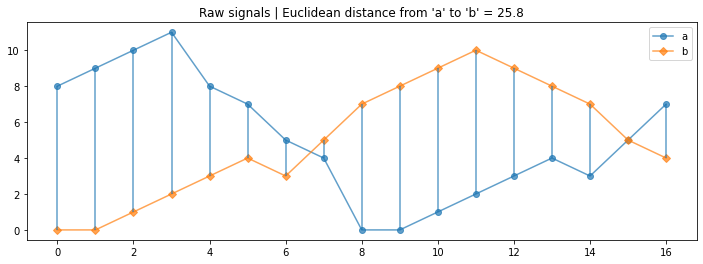

In [58]:
a = [8, 9, 10, 11, 8, 7, 5, 4, 0, 0, 1, 2, 3, 4, 3, 5, 7]
b = [0, 0, 1, 2, 3, 4, 3, 5, 7, 8, 9, 10, 9, 8, 7, 5, 4]

euclid_distance_a_to_b = distance.euclidean(a, b)

fig, axes = plt.subplots(1, 1, figsize=(12, 4))
axes.plot(a, alpha=0.7, label="a", marker="o")
axes.plot(b, alpha=0.7, label="b", marker="D")

# draw connecting segments between a_i and b_i used for Euclidean distance calculation
axes.vlines(np.arange(0, len(a), 1), a, b, alpha = 0.7)
axes.legend()
axes.set_title("Raw signals | Euclidean distance from 'a' to 'b' = {:0.1f}".format(euclid_distance_a_to_b));

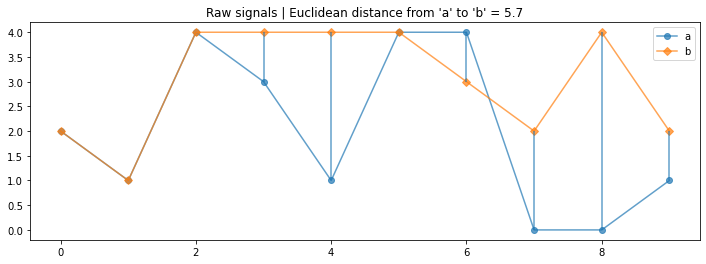

In [59]:
np.random.seed(None)
a = np.random.randint(0, 5, 10)
b = np.random.randint(0, 5, 10)

euclid_distance_a_to_b = distance.euclidean(a, b)

fig, axes = plt.subplots(1, 1, figsize=(12, 4))
axes.plot(a, alpha=0.7, label="a", marker="o")
axes.plot(b, alpha=0.7, label="b", marker="D")

# draw connecting segments between a_i and b_i used for Euclidean distance calculation
axes.vlines(np.arange(0, len(a), 1), a, b, alpha = 0.7)
axes.legend()
axes.set_title("Raw signals | Euclidean distance from 'a' to 'b' = {:0.1f}".format(euclid_distance_a_to_b));

In [60]:
a = [0, 1, 2, 3, 4, 5, 6, 7]
b = [3, 4, 5]

padding_length = len(a) - len(b)

# Pad using zero to the right of the array
b_padded_zero_right = np.pad(b, (0, padding_length), mode = 'constant', constant_values=0)
print(a, len(a))
print(b, len(b))
print(b_padded_zero_right, len(b_padded_zero_right))

[0, 1, 2, 3, 4, 5, 6, 7] 8
[3, 4, 5] 3
[3 4 5 0 0 0 0 0] 8


In [61]:
# Pad with constant value zero to left of the array
b_padded_zero_left = np.pad(b, (padding_length, 0), mode = 'constant', constant_values=0)

print(a, len(a))
print(b, len(b))
print(b_padded_zero_left, len(b_padded_zero_left))

[0, 1, 2, 3, 4, 5, 6, 7] 8
[3, 4, 5] 3
[0 0 0 0 0 3 4 5] 8


In [62]:
# Pad with zero in both directions
b_padded_zero_bothdirs = np.pad(b, (math.floor(padding_length/2.0), math.ceil(padding_length/2.0)), 
                                mode = 'constant', constant_values=0)
print(a, len(a))
print(b, len(b))
print(b_padded_zero_bothdirs, len(b_padded_zero_bothdirs))

[0, 1, 2, 3, 4, 5, 6, 7] 8
[3, 4, 5] 3
[0 0 3 4 5 0 0 0] 8


In [63]:
# Pad to the right with the mean of 'b'
b_padded_mean_right = np.pad(b, (0, padding_length), mode = 'mean')

print(a, len(a))
print(b, len(b))
print(b_padded_mean_right, len(b_padded_mean_right))

[0, 1, 2, 3, 4, 5, 6, 7] 8
[3, 4, 5] 3
[3 4 5 4 4 4 4 4] 8


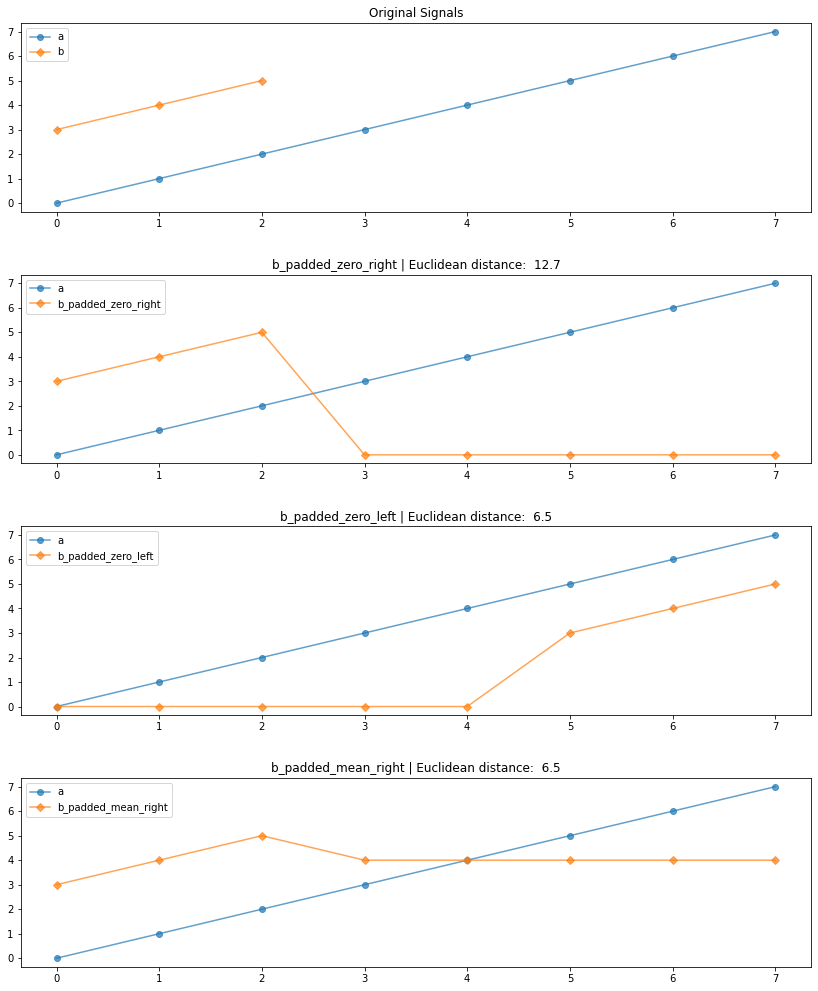

In [64]:
num_charts = 4
chart_height = 3.6
fig, axes = plt.subplots(num_charts, 1, figsize=(12, num_charts * chart_height))
    
# Turn on markers only if < 50 points
a_marker = None
b_marker = None
if len(a) < 50:
    a_marker = "o"
    b_marker = "D"

axes[0].plot(a, alpha=0.7, label="a", marker="o")
axes[0].plot(b, alpha=0.7, label="b", marker="D")
axes[0].legend()
axes[0].set_title(f"Original Signals")

axes[1].plot(a, alpha=0.7, label="a", marker="o")
axes[1].plot(b_padded_zero_right, alpha=0.7, label="b_padded_zero_right", marker="D")
axes[1].legend()
axes[1].set_title(f"b_padded_zero_right | Euclidean distance: {distance.euclidean(a, b_padded_zero_right): .1f}")

axes[2].plot(a, alpha=0.7, label="a", marker="o")
axes[2].plot(b_padded_zero_left, alpha=0.7, label="b_padded_zero_left", marker="D")
axes[2].legend()
axes[2].set_title(f"b_padded_zero_left | Euclidean distance: {distance.euclidean(a, b_padded_zero_left): .1f}")

axes[3].plot(a, alpha=0.7, label="a", marker="o")
axes[3].plot(b_padded_mean_right, alpha=0.7, label="b_padded_mean_right", marker="D")
axes[3].legend()
axes[3].set_title(f"b_padded_mean_right | Euclidean distance: {distance.euclidean(a, b_padded_mean_right): .1f}")

fig.tight_layout(pad=3)

In [65]:
a = [0, 1, 2, 3, 4, 3, 2]
b = [0, 0, 1, 2, 3, 4, 3]
correlate_result = np.correlate(a, b, 'full')
b_shift_positions = np.arange(-len(a) + 1, len(b))
print(b_shift_positions) # The shift positions of b
print(correlate_result)

[-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
[ 0  3 10 20 32 39 38 28 16  7  2  0  0]


len(a) 7 len(b) 7 len(correlate_result) 13
[-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
[ 0  3 10 20 32 39 38 28 16  7  2  0  0]
best_correlation_index 5 shift_amount_debug -1 shift_amount -1


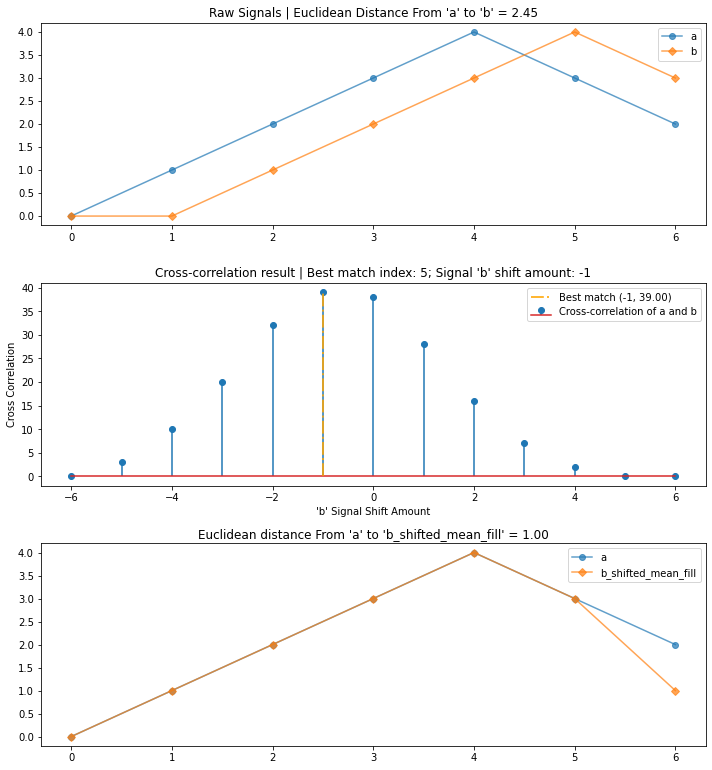

In [66]:
b_shift = b_shift = compare_and_plot_signals_with_alignment(a, b)

len(a) 7 len(b) 7 len(correlate_result) 13
[-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
[ 0  3 10 20 32 39 38 28 16  7  2  0  0]
best_correlation_index 5 shift_amount_debug -1 shift_amount -1


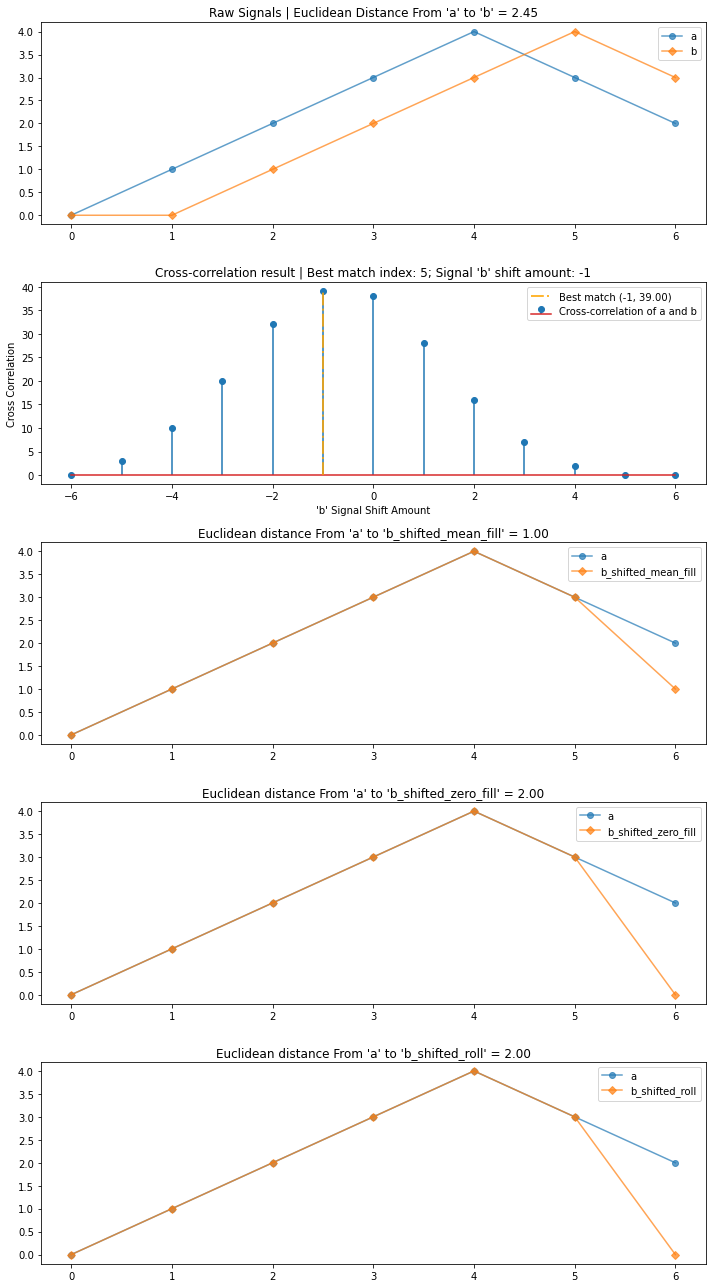

In [67]:
a = [0, 1, 2, 3, 4, 3, 2]
b = [0, 0, 1, 2, 3, 4, 3]
b_shift = compare_and_plot_signals_with_alignment(a, b, bshift_method = 'all')

len(a) 17 len(b) 17 len(correlate_result) 33
best_correlation_index 8 shift_amount_debug -8 shift_amount -8


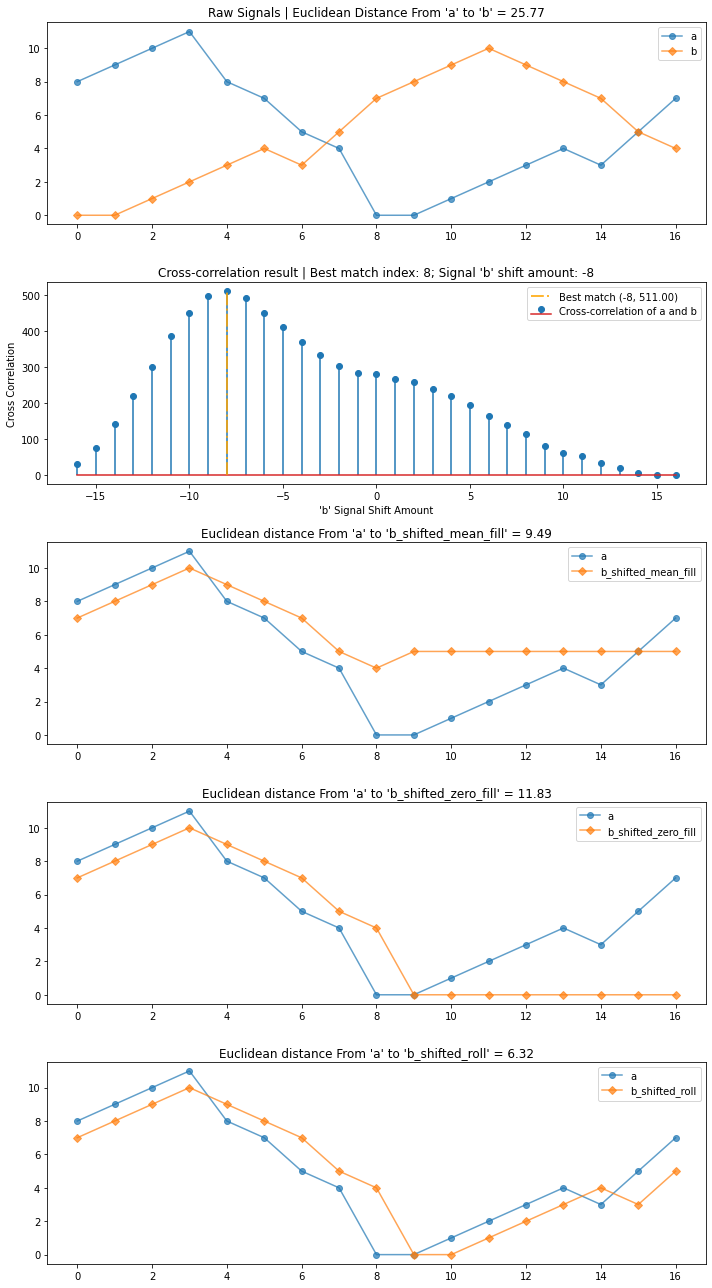

In [68]:
a = [8, 9, 10, 11, 8, 7, 5, 4, 0, 0, 1, 2, 3, 4, 3, 5, 7]
b = [0, 0, 1, 2, 3, 4, 3, 5, 7, 8, 9, 10, 9, 8, 7, 5, 4]
b_shift = compare_and_plot_signals_with_alignment(a, b, bshift_method = "all")

200
len(a) 200 len(b) 200 len(correlate_result) 399
best_correlation_index 209 shift_amount_debug 10 shift_amount 10


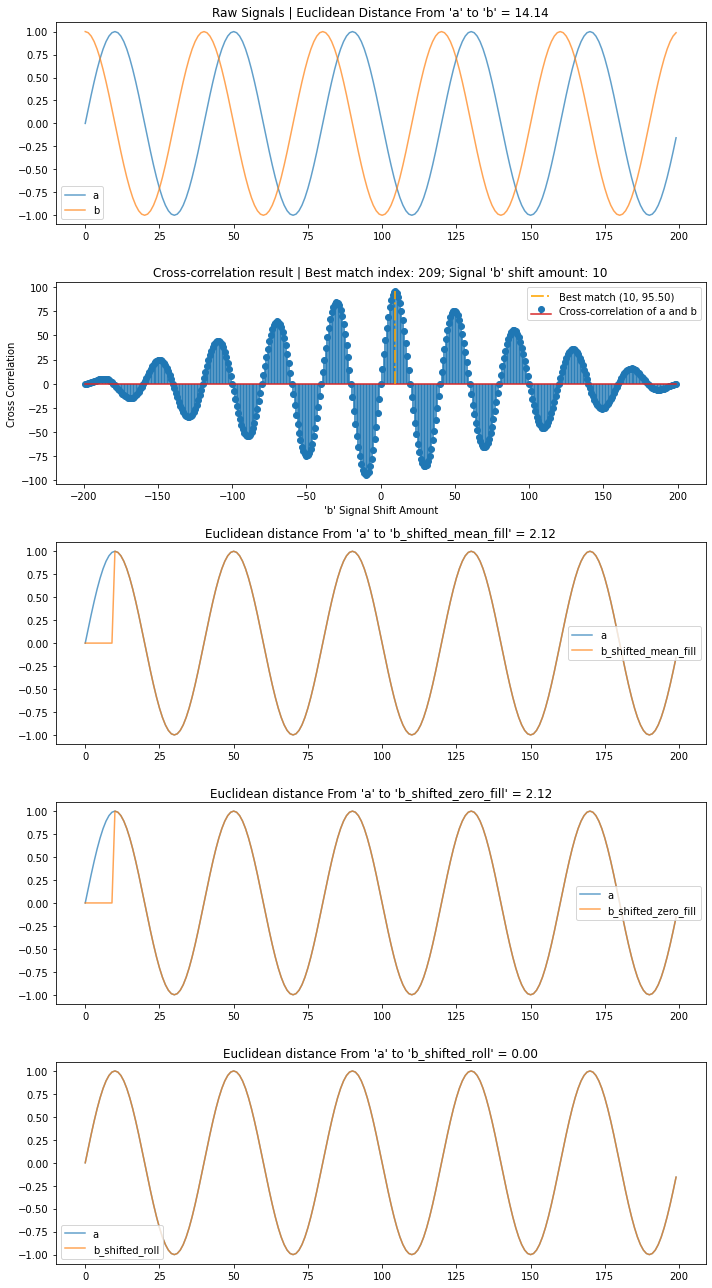

In [69]:
# Create and plot a simple sine and cos wave
total_time_in_secs = 1
sampling_rate = 200
freq = 5

sine_wave = create_sine_wave(freq, sampling_rate, total_time_in_secs)
cos_wave = create_cos_wave(freq, sampling_rate, total_time_in_secs)
print(len(cos_wave))
b_shift = compare_and_plot_signals_with_alignment(sine_wave, cos_wave, bshift_method = 'all')

len(a) 200 len(b) 200 len(correlate_result) 399
best_correlation_index 169 shift_amount_debug -30 shift_amount -30


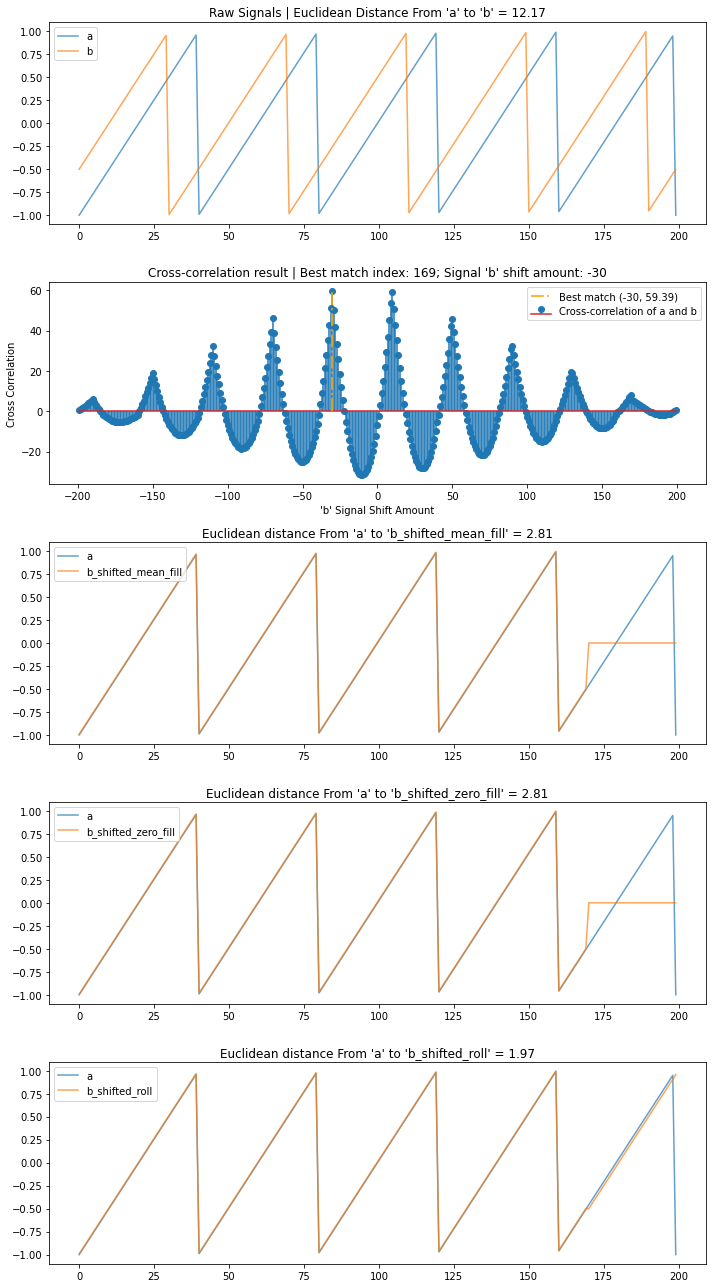

In [70]:
total_time_in_secs = 1
sampling_rate = 200
freq = 5

t = np.linspace(0, total_time_in_secs, sampling_rate)
sawtooth_a = sp.signal.sawtooth(2 * np.pi * freq * t)
sawtooth_b = sp.signal.sawtooth(2 * np.pi * freq * t + np.pi/2)

b_shift = compare_and_plot_signals_with_alignment(sawtooth_a, sawtooth_b, bshift_method = 'all')

len(a) 7 len(b) 7 len(correlate_result) 13
[-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
[12  4 28 20 20 32 17 19 16  3  0  0  0]
best_correlation_index 5 shift_amount_debug -1 shift_amount -1


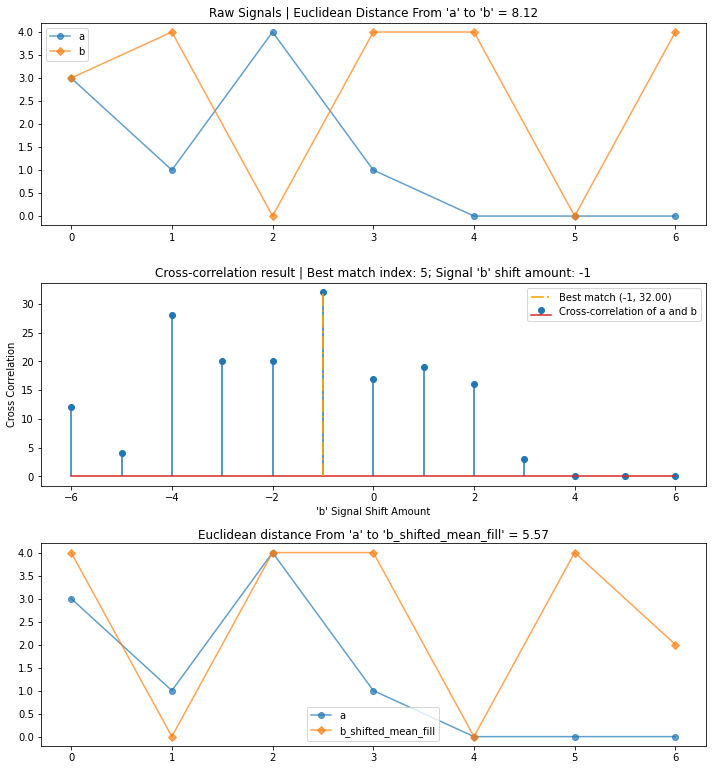

In [71]:
np.random.seed(None)
a = np.random.randint(0, 5, 7)
b = np.random.randint(0, 5, 7)
b_shift = compare_and_plot_signals_with_alignment(a, b)

Read in donateacry-corpus-master/donateacry_corpus_cleaned_and_updated_data/belly_pain/69BDA5D6-0276-4462-9BF7-951799563728-1436936185-1.1-m-26-bp.wav
Sampling rate: 3000 Hz
Number of channels = 1
Total samples: 21000


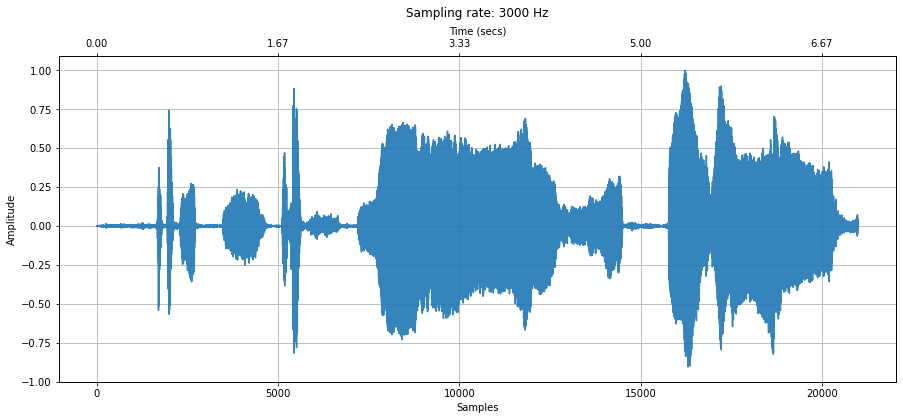

In [72]:
read_in_sampling_rate = 3000 # 3,000 Hz is the lowest sampling rate that will play in Chrome

sound_file = 'donateacry-corpus-master/donateacry_corpus_cleaned_and_updated_data/belly_pain/69BDA5D6-0276-4462-9BF7-951799563728-1436936185-1.1-m-26-bp.wav'
guitar_pluck_six_strings, sampling_rate = librosa.load(sound_file, sr=read_in_sampling_rate)
guitar_pluck_six_strings = librosa.util.normalize(guitar_pluck_six_strings)
print(f"Read in {sound_file}")
print(f"Sampling rate: {sampling_rate} Hz")
print(f"Number of channels = {len(guitar_pluck_six_strings.shape)}")
print(f"Total samples: {guitar_pluck_six_strings.shape[0]}")

# Notice how you can see the six strings being plucked
# The 'A' string is the second string on the guitar, so it's the second
# sound envelope showing in the visualization
# Listen to the recording as well
plot_signal(guitar_pluck_six_strings, sampling_rate)
ipd.Audio(guitar_pluck_six_strings, rate=sampling_rate)

Read in donateacry-corpus-master/donateacry_corpus_cleaned_and_updated_data/belly_pain/549a46d8-9c84-430e-ade8-97eae2bef787-1430130772174-1.7-m-48-bp.wav
Sampling rate: 3000 Hz
Number of channels = 1
Total samples: 20580


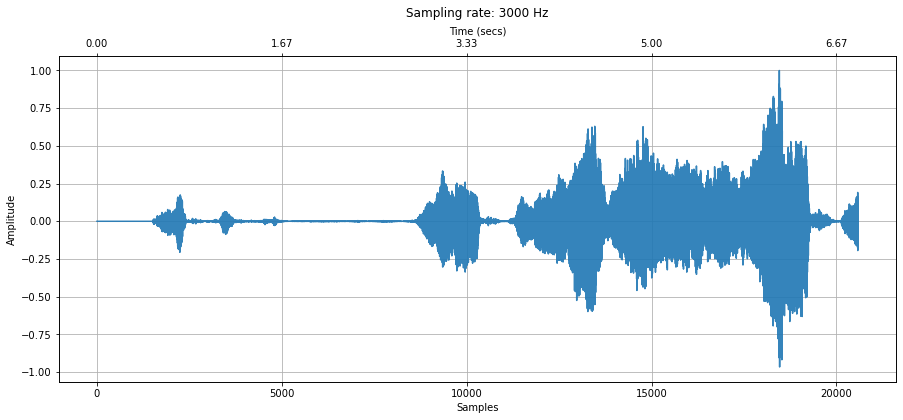

In [73]:
sound_file = 'donateacry-corpus-master/donateacry_corpus_cleaned_and_updated_data/belly_pain/549a46d8-9c84-430e-ade8-97eae2bef787-1430130772174-1.7-m-48-bp.wav'
guiter_pluck_a_string, sampling_rate = librosa.load(sound_file, sr=read_in_sampling_rate)
guiter_pluck_a_string = librosa.util.normalize(guiter_pluck_a_string)
print(f"Read in {sound_file}")
print(f"Sampling rate: {sampling_rate} Hz")
print(f"Number of channels = {len(guiter_pluck_a_string.shape)}")
print(f"Total samples: {guiter_pluck_a_string.shape[0]}")
plot_signal(guiter_pluck_a_string, sampling_rate)
ipd.Audio(guiter_pluck_a_string, rate=sampling_rate)

len(a) 21000 len(b) 21000 len(correlate_result) 41999
best_correlation_index 25052 shift_amount_debug 4053 shift_amount 4053


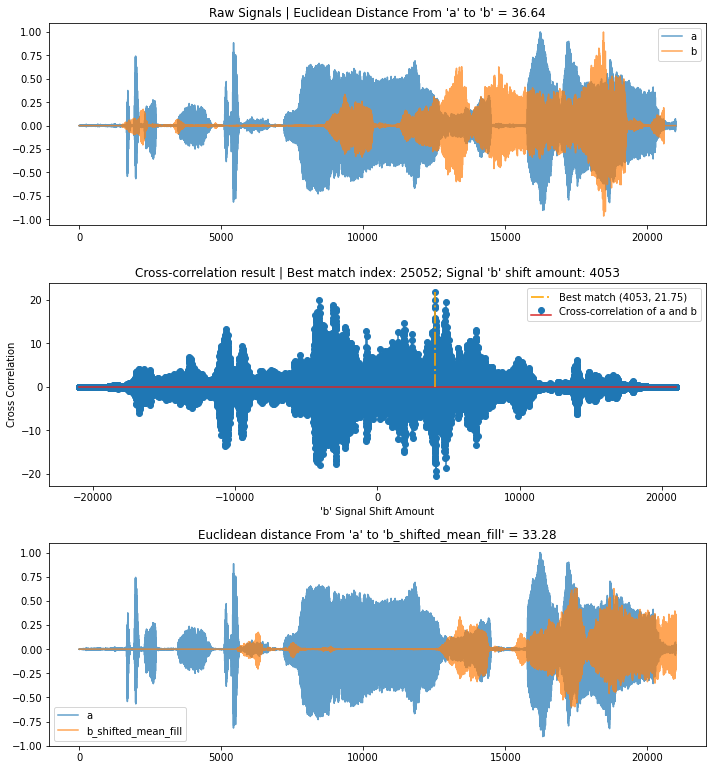

In [74]:
a = guitar_pluck_six_strings
b = guiter_pluck_a_string
# If we appropriately find guiter_pluck_a_string in guitar_pluck_six_strings
# then we will shift b to align with a at the second plucked string (which is the A string)
b_shift = compare_and_plot_signals_with_alignment(a, b, pad_function = pad_zeros_right)

In [75]:
a = [0, 1, 2, 3, 4, 3, 2]
b = [0, 0, 1, 2, 3, 4, 3]
d, path = fastdtw.fastdtw(a, b, dist=distance.euclidean)
print(d)
print(path)

1.0
[(0, 0), (0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 6)]


In [76]:
def cross_correlation_using_fft(x, y):
    f1 = fft(x)
    f2 = fft(np.flipud(y))
    cc = np.real(ifft(f1 * f2))
    return fftshift(cc)
 
# shift &lt; 0 means that y starts 'shift' time steps before x # shift &gt; 0 means that y starts 'shift' time steps after x
def compute_shift(x, y):
    assert len(x) == len(y)
    c = cross_correlation_using_fft(x, y)
    assert len(c) == len(x)
    zero_index = int(len(x) / 2) - 1
    shift = zero_index - np.argmax(c)
    return shift

Read in donateacry-corpus-master/donateacry_corpus_cleaned_and_updated_data/belly_pain/69BDA5D6-0276-4462-9BF7-951799563728-1436936185-1.1-m-26-bp.wav
Sampling rate: 3000 Hz
Number of channels = 1
Total samples: 21000


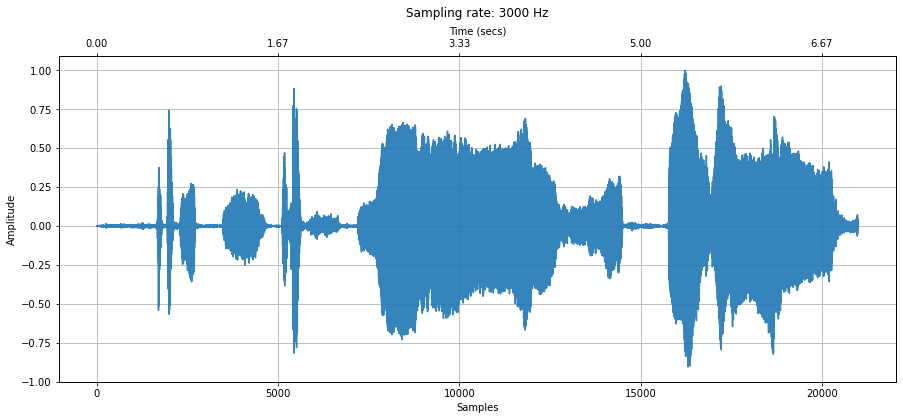

In [77]:
sound_file = 'donateacry-corpus-master/donateacry_corpus_cleaned_and_updated_data/belly_pain/69BDA5D6-0276-4462-9BF7-951799563728-1436936185-1.1-m-26-bp.wav'
belly_pain_1, sampling_rate = librosa.load(sound_file, sr=read_in_sampling_rate)
belly_pain_1 = librosa.util.normalize(belly_pain_1)
print(f"Read in {sound_file}")
print(f"Sampling rate: {sampling_rate} Hz")
print(f"Number of channels = {len(belly_pain_1.shape)}")
print(f"Total samples: {belly_pain_1.shape[0]}")
plot_signal(belly_pain_1, sampling_rate)
ipd.Audio(belly_pain_1, rate=sampling_rate)

Read in donateacry-corpus-master/donateacry_corpus_cleaned_and_updated_data/belly_pain/549a46d8-9c84-430e-ade8-97eae2bef787-1430130772174-1.7-m-48-bp.wav
Sampling rate: 3000 Hz
Number of channels = 1
Total samples: 20580


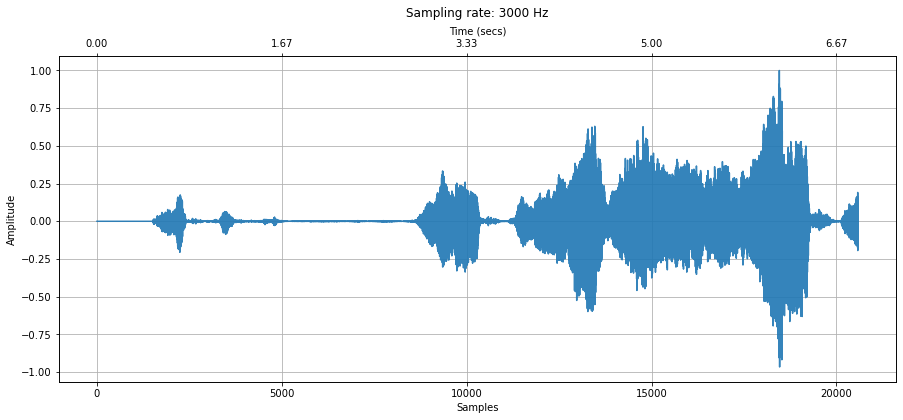

In [78]:
sound_file = 'donateacry-corpus-master/donateacry_corpus_cleaned_and_updated_data/belly_pain/549a46d8-9c84-430e-ade8-97eae2bef787-1430130772174-1.7-m-48-bp.wav'
belly_pain_2, sampling_rate = librosa.load(sound_file, sr=read_in_sampling_rate)
belly_pain_2 = librosa.util.normalize(belly_pain_2)
print(f"Read in {sound_file}")
print(f"Sampling rate: {sampling_rate} Hz")
print(f"Number of channels = {len(belly_pain_2.shape)}")
print(f"Total samples: {belly_pain_2.shape[0]}")
plot_signal(belly_pain_2, sampling_rate)
ipd.Audio(belly_pain_2, rate=sampling_rate)

len(a) 21000 len(b) 21000 len(correlate_result) 41999
best_correlation_index 14302 shift_amount_debug -6697 shift_amount -6697
len(a) 21000 len(b) 21000 len(correlate_result) 41999
best_correlation_index 13045 shift_amount_debug -7954 shift_amount -7954


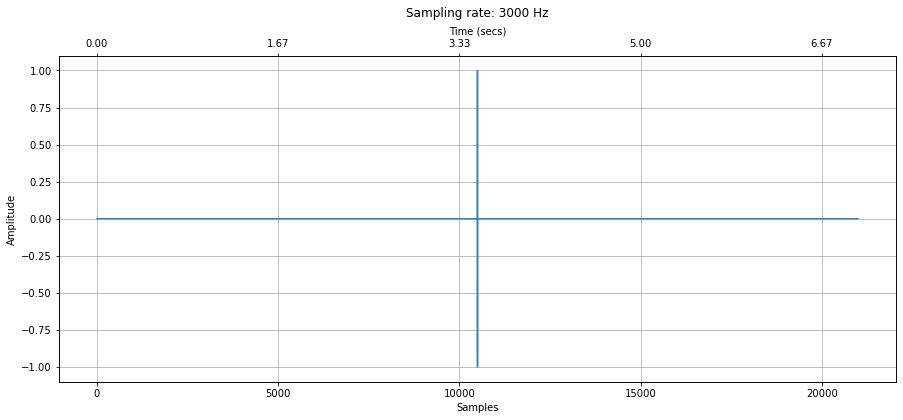

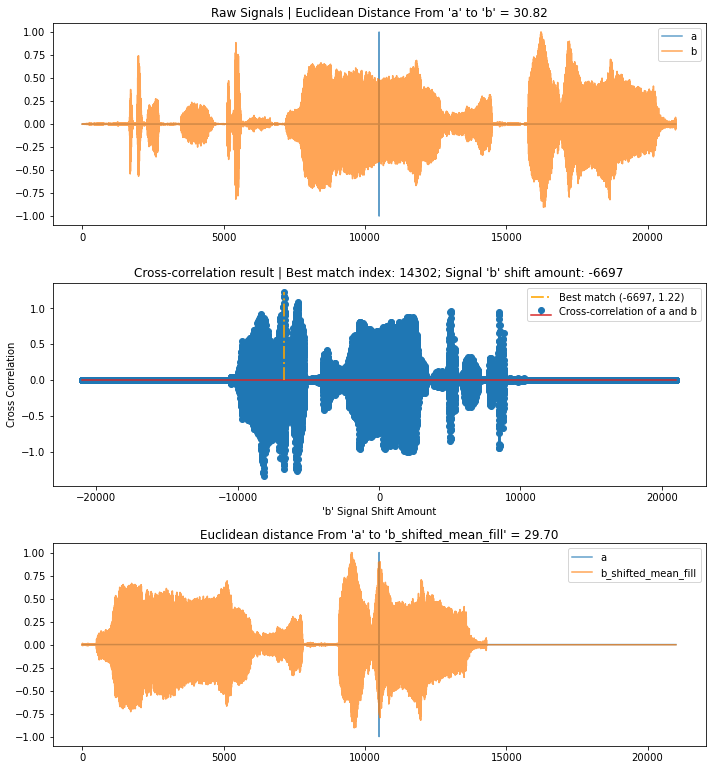

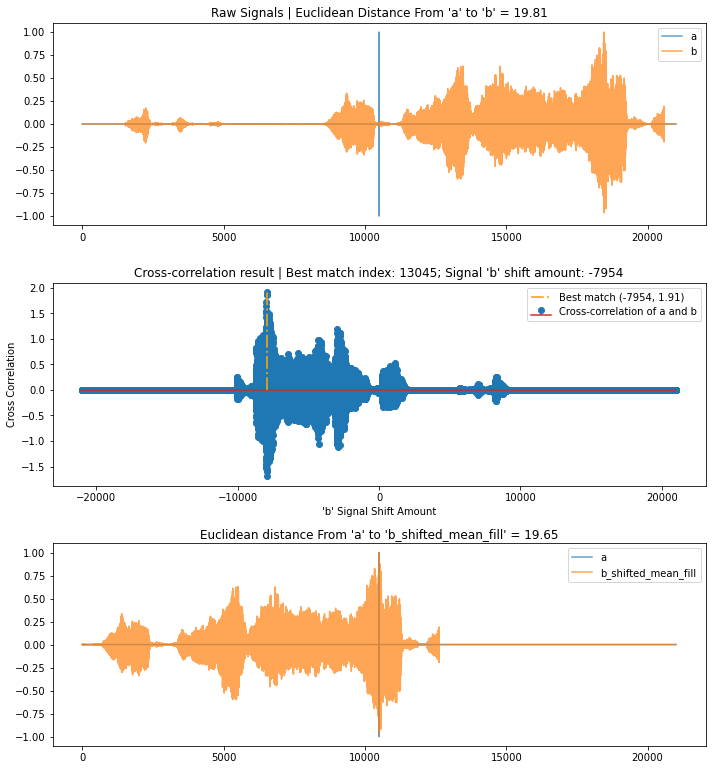

In [79]:
aligner = np.zeros(belly_pain_1.shape[0])
aligner[int(belly_pain_1.shape[0]/2)] = 1
aligner[int(belly_pain_1.shape[0]/2) + 1] = -1
plot_signal(aligner, sampling_rate)
b_shift_1 = compare_and_plot_signals_with_alignment(aligner, belly_pain_1, pad_function = pad_zeros_right)
b_shift_2 = compare_and_plot_signals_with_alignment(aligner, belly_pain_2, pad_function = pad_zeros_right)

len(a) 21000 len(b) 21000 len(correlate_result) 41999
best_correlation_index 26309 shift_amount_debug 5310 shift_amount 5310


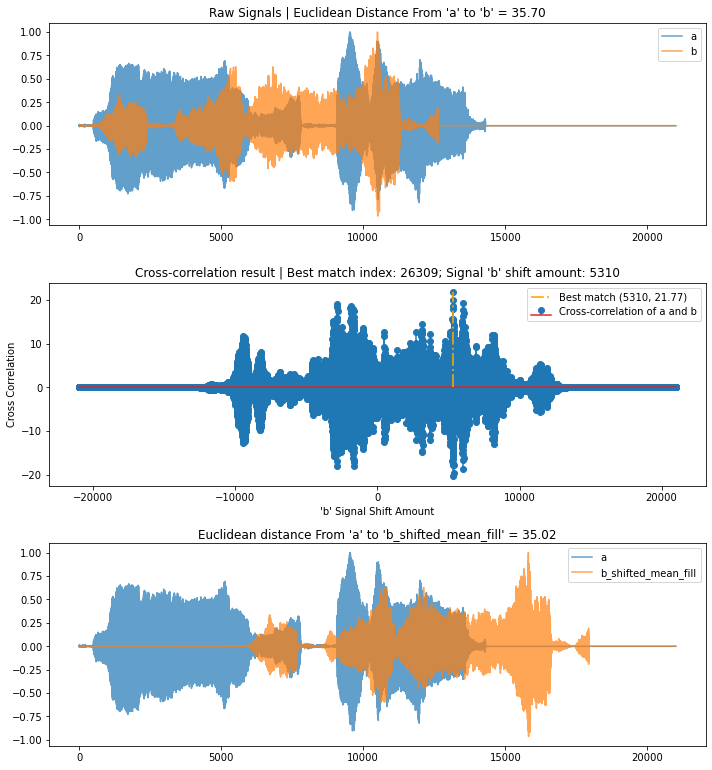

In [80]:
shift = compare_and_plot_signals_with_alignment(b_shift_1, b_shift_2, pad_function = pad_zeros_right)